In [38]:
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt

from centrex_tlf import states, hamiltonian
from centrex_trajectories.utils import fit_stark_potential

plt.rcParams.update({'font.size':14})

In [26]:
# generate states up to J=9
QN = states.generate_uncoupled_states_ground(Js=np.arange(10))

# generate the X hamiltonian terms
H = hamiltonian.generate_uncoupled_hamiltonian_X(QN)

# create a function outputting the hamiltonian as a function of E and B
Hfunc = hamiltonian.generate_uncoupled_hamiltonian_X_function(H)

# V/cm
Ez = np.linspace(0, 50e3, 101)

# generate the Hamiltonian for (almost) zero field, add a small field to make states
# non-degenerate
Hi = Hfunc(E=[0, 0, 1e-3], B=[0, 0, 1e-3])
E, V = np.linalg.eigh(Hi)

# get the true superposition-states of the system
QN_states = hamiltonian.matrix_to_states(V, QN)

# original eigenvectors used in tracking states as energies change order
V_track = V.copy()

# indices of the J=2, mJ=0 states focused by the lens
indices_J2_mJ0 = [
    idx
    for idx, s in enumerate(QN_states)
    if s.largest.J == 2 and s.largest.mJ == 0
]

indices_J012 = [
    idx for idx, s in enumerate(QN_states) if s.largest.J in [0, 1, 2]
]

# empty array for storing energies
energies = np.empty([Ez.size, len(QN)], dtype=np.complex128)

# iterate over the electric field values
for idx, Ei in enumerate(Ez):
    Hi = Hfunc(E=[0, 0, Ei], B=[0, 0, 1e-3])
    E, V = np.linalg.eigh(Hi)

    # sort indices to keep the state order the same
    indices = np.argmax(np.abs(V_track.conj().T @ V), axis=1)
    energies[idx, :] = E[indices]
    V_track[:, :] = V[:, indices]


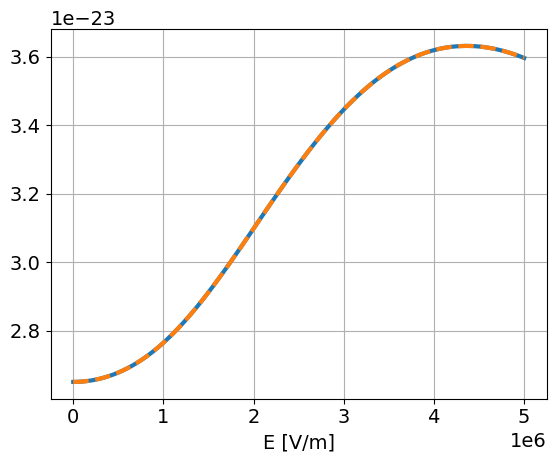

In [44]:
# convert to V/m
Ez_Vm = Ez*100

# grab energy of J=2, mJ=0
energy = energies.real[:, indices_J2_mJ0[0]] * constants.h / (2*np.pi)

fit_coeff = fit_stark_potential(Ez_Vm, energy, deg=11)
fit = np.polynomial.Polynomial(coef=fit_coeff)

fig, ax = plt.subplots()
ax.plot(Ez_Vm, energy, lw = 3)
ax.plot(Ez_Vm, fit(Ez_Vm), ls='--', lw = 3)
ax.set_xlabel("E [V/m]")
ax.set_ylabel("")
ax.grid(True)

In [50]:
import pickle
with open("stark_poly.pkl", "wb") as f:
    pickle.dump(fit_coeff, f)